# Setup

In [2]:
# import libs
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
from PIL import Image
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from datetime import datetime
from sklearn.model_selection import train_test_split



# Global Variables

In [3]:
# Global variables
channel_dict = {
    'RGB' : 3,
    'RGBcanny' : 4,
    'Grayscale' : 1,
    'Canny' : 1
}

fruit_array = ["apple","banana", "orange", "mixed"]

# Instanced Variables

In [4]:
# Set Variables
img_size = 64 #16
epochs = 64
batchsize= 10
validation_split=0.1

# Model Variant- See Function Definitions (Model Augmentation)
var_model = 'Else' #'001'

# Data Variant- See \ML_Proj_Data\train
var_data = '01EDIT' #'00BASE' #'02EDIT'  

# Augmentation Variant- See
var_aug= ['RGBcanny', None] #'RGB' # 'RGBcanny' # 'Grayscale' # 'Canny'


# Automatic Variables
model_data_id = '[{model}]-[{data}]-[{imgaug01}]-[{imgaug02}]'.format(
    model=var_model,
    data=var_data,    
    imgaug01=var_aug[0],
    imgaug02=var_aug[1]) 
channels=channel_dict[var_aug[0]]


# Functions

## Function Definitions (Image Augmentation)

In [5]:
def first_augmentation_step(first_aug, img):
    '''
    For pre-processing image channels- Edge maps, color, etc.
    ALWAYS accept and return a PIL image
    ALWAYS return a PIL image, even if preprocessing with CV2
    '''

    if  first_aug=='RGB':
        return img
    
    elif first_aug=='RGBcanny':
        #convert to np ndarray
        PIL_array = np.array(img)

        ## debugging
        # print(type(PIL_array)) #np.ndarray
        # print(PIL_array.shape) #349,3

        cv2_image = cv2.cvtColor(PIL_array, cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY) #convert to grayscale
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 30, 100)

        ## debugging
        # print(type(edges)) #np.ndarray
        # print(edges.shape) #349,

        final_img_array = np.dstack((PIL_array, edges))
        RGBwMap = Image.fromarray(final_img_array)
        return RGBwMap
    
    elif first_aug=='Grayscale':
        PIL_array = np.array(img)

        # need this line in case the image type is 'P'
        # error:
            # Invalid number of channels in input image:
            # >     'VScn::contains(scn)'
            # > where
            # >     'scn' is 1
        cv2_image = cv2.cvtColor(PIL_array, cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY)

        #final_img_array = cv2_image.numpy()
        grayscale = Image.fromarray(cv2_image)

        return grayscale
    
    elif first_aug=='Canny':
        PIL_array = np.array(img)

        cv2_image = cv2.cvtColor(PIL_array, cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY) #convert to grayscale
        
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.Canny(blurred, 30, 100)

        canny = Image.fromarray(edges)
        return canny
    
    else:
        print('ERROR: No image augmentation selected!')
    

In [6]:
def second_augmentation_step(second_aug, img):
    '''
    For pre-processing image loci- translation, rotation, zooming, flipping 
    ALWAYS accept and return a PIL image
    '''
    if second_aug=='test':
        print('Testing image augmentation')
        return img
    else:
        return img
    

## Function Definitions (Model Augmentation)

In [7]:
def create_model(input_dimension=224, channels=3, model_type=None, num_classifications=4):
    '''
    Create a model
    Use 'flatten' or 'pooling' depending on settings
    '''
    model = tf.keras.Sequential()
    num_classifications=num_classifications
    
    if model_type=='000':
        # engel test
        model.add(tf.keras.layers.Conv2D(
            filters = 64, 
            kernel_size = (3,3),
            activation = 'relu', 
            input_shape = (input_dimension,input_dimension,channels)))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))
        model.add(tf.keras.layers.Conv2D(
            filters = 64, 
            kernel_size = (3,3),
            activation = 'relu', 
            input_shape = (input_dimension,input_dimension,channels)))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))

        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        
    elif model_type=='001':
        # engel edit
        model.add(tf.keras.layers.Conv2D(
            filters = 32, 
            kernel_size = (3,3),
            activation = 'relu', 
            input_shape = (input_dimension,input_dimension,channels)))
        model.add(tf.keras.layers.Conv2D(
            filters = 32, 
            kernel_size = (3,3),
            activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))

        model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
        model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))

        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dense(units=64, activation='relu'))

    elif model_type=='002':
        # cherwah's recommendation on kernel size
        model.add(tf.keras.layers.Conv2D(
            filters = 32, 
            kernel_size = (7,7),
            activation = 'relu', 
            input_shape = (input_dimension,input_dimension,channels)))
        model.add(tf.keras.layers.Conv2D(
            filters = 32, 
            kernel_size = (5,5),
            activation='relu'))
        model.add(tf.keras.layers.Conv2D(
            filters = 32, 
            kernel_size = (5,5),
            activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))

        model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
        model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))

        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    else:
        # ref- engel model
        model.add(tf.keras.layers.Conv2D(
            filters = 32, 
            kernel_size = (3,3),
            activation = 'relu', 
            input_shape = (input_dimension,input_dimension,channels)))
        model.add(tf.keras.layers.Conv2D(
            filters = 32, 
            kernel_size = (3,3),
            activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))

        model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
        model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
        model.add(tf.keras.layers.MaxPooling2D((2,2),(2,2)))

        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))

    # Final layer
    # 4 classifications- Apple, Banana, Orange, Mixed
    model.add(tf.keras.layers.Dense(units=num_classifications, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    return model

## Function Definitions (General)

In [8]:
# define func

def show_image(X_train,index):
    '''
    Display the image at the specific index of the reshaped array
    '''
    if not index  < X_train.shape[0]:
        print("Array does not contain your desired image index.")
    image_array = X_train[index]
    image = Image.fromarray(np.uint8(image_array))
    image.show()

def prep_train_data(subfolder_name, desired_size, var_aug_type):
    new_size = desired_size
    paths = []
    
    for fruit in fruit_array:
        paths.append('ML_Proj_Data/train/{subfolder}/{fruit}'.format(subfolder=subfolder_name,fruit=fruit))

    return prep_data(paths,new_size,var_aug_type)

def prep_test_data(desired_size, var_aug_type):
    new_size = desired_size
    paths = []

    for fruit in fruit_array:
        paths.append('ML_Proj_Data/test/{fruit}'.format(fruit=fruit))

    return prep_data(paths,new_size, var_aug_type)

def prep_data(paths, desired_size, var_aug_type):
    '''
    Pre-process all images in each of the 4 paths.
    '''
    new_size = desired_size

    for i in range(len(paths)):
        data = read_img_data(paths[i],new_size, var_aug_type)
        
        #test if it works by showing image
        # show_image(data,0)
        # show_image(data,1)

        try: 
            # concatenate if initialized
            X = np.concatenate((X,data))
        except:
            # initialize if not
            X = data

        y_onehots = map_type_to_onehot(paths[i], data.shape[0])
        try:
            y = np.concatenate((y,y_onehots))
        except:
            y = y_onehots
        
    return X,y

def map_type_to_onehot(file_path, n_rows):
    '''
    Map the type of image to digit.
    Takes in a specific file path.
    Returns a onehot encoded 1D array.
    '''
    y_onehot = [0]*4
    fruit_onehot_dict =	{
    "apple": [1,0,0,0],
    "banana": [0,1,0,0],
    "orange": [0,0,1,0],
    "mixed": [0,0,0,1]
    }

    normalized_path = file_path.replace('\\','/')
    segments = normalized_path.split('/')
    final_segment = segments[-1]

    if '.jpg' in final_segment:
        # incorrect path structure but handle it anyway
        prefix = final_segment.split('_')[0]
    else:
        prefix = final_segment

    if prefix in fruit_onehot_dict:
        y_onehot =  fruit_onehot_dict[prefix]

    y_onehots = [y_onehot] * n_rows
    # convert python list to numpy array
    # as keras requires numpy array
    return np.array(y_onehots)

def read_img_data(path, desired_size, var_aug_type):
    '''
    Loops through every file in a specific path
    Opens, pre-processes, and adds each image to X_train
    '''

    for file in os.listdir(path):
        if file[0] == '.':  # skip hidden files
            continue

        img = Image.open("{path}/{file}".format(path=path,file=file))
        img = preprocess_image(img, desired_size, var_aug_type)
    
        try:
            # concatenate every subsequent img to x_train after it has been initialized at (i=0)
            X_train = np.concatenate((X_train, img))
        except:
            # initialize x_train and assign img to it as the first value if it does not exist (i=0)
            X_train = img

            #code for ndim canny map in channels in np.reshape
            channels=channel_dict[var_aug_type[0]]
    
    # returns the entire folder of images as a single array

    return np.reshape(X_train, (-1,desired_size,desired_size,channels))


def preprocess_image(img, desired_size, var_aug_type):
    '''
    Pre-process specific image object ONLY.
    Convert to RGB to reduce unnecessary features (remove alpha, ndim 4-> 3) and increase training speed.
    (!) must be for looped!
    '''
    # new 2D image size
    new_size = (desired_size,desired_size)

    # remove alpha channel
    if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):
        #convert to RGBA to use alpha_composite function
        img = img.convert('RGBA')
        bg = Image.new('RGBA',img.size, (255, 255, 255))

        bg.alpha_composite(img, (0,0))
        img = bg.convert('RGB')

        if img.mode != 'RGB':
            img = img.convert('RGB')

    img_aug1 = first_augmentation_step(first_aug=var_aug_type[0], img=img)

    resized_img = img_aug1.resize(new_size)

    img_aug2 = second_augmentation_step(second_aug=var_aug_type[1], img=resized_img)

    return img_aug2

def save_model(model, path_fragment):
    path = 'ML_Proj_Data/model/{pathfragment}'.format(pathfragment=path_fragment)
    model.save(path)

def load_model(path_fragment):
    path = 'ML_Proj_Data/model/{pathfragment}'.format(pathfragment=path_fragment)
    return tf.keras.models.load_model(path)

def test_model(model, X_test, y_test):
    return model.evaluate(x=X_test, y=y_test)


# Model Training and Fitting

## Data Preparation

In [9]:
# Prep training, validation and test data

X_data, y_data = prep_train_data(subfolder_name=var_data, desired_size=img_size, var_aug_type=var_aug)

X_train, X_validate, y_train, y_validate = train_test_split(X_data, y_data, test_size=validation_split, stratify=y_data)

X_test, y_test = prep_test_data(img_size, var_aug_type=var_aug)

print('X_train: {X_train}, y_train: {y_train}'.format(X_train=X_train.shape, y_train=y_train.shape))
print('X_validate: {X_validate}, y_validate: {y_validate}'.format(X_validate=X_validate.shape, y_validate=y_validate.shape))
print('X_test: {X_test}, y_test: {y_test}'.format(X_test=X_test.shape, y_test=y_test.shape))


X_train: (267, 64, 64, 4), y_train: (267, 4)
X_validate: (30, 64, 64, 4), y_validate: (30, 4)
X_test: (60, 64, 64, 4), y_test: (60, 4)


## (Optional) Check Validation Set

In [10]:
# Check if validation sample is evenly distributed

# print(type(y_validate))
yv_urows, yv_counts = np.unique(y_validate, axis=0, return_counts=True)
print ("Onehots= {}".format(yv_urows))
print ("Onehot data distribution count= {}".format(yv_counts))

Onehots= [[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]
Onehot data distribution count= [8 7 7 8]


## Create and Fit Model

In [11]:
# Create
model = create_model(input_dimension=img_size, channels = channels, model_type=var_model)
now = datetime.now()
csv_logger = CSVLogger('LOG-[{modeltype}]-[{dataset}]-[{imgaug01}]-[{imgaug02}]-[{date}]-[{time}].csv'.format(
    modeltype=var_model,
    dataset=var_data,
    imgaug01=var_aug[0],
    imgaug02=var_aug[1],
    date=now.strftime("%Y%m%d"),
    time=now.strftime("%H%M%S")))
early_stopping = EarlyStopping(monitor='accuracy', patience=5)

# Train and Save

callback = model.fit(x=X_train/255, y=y_train, batch_size=batchsize, epochs=epochs, validation_data=(X_validate/255,y_validate), callbacks = [early_stopping,csv_logger])
save_model(model,model_data_id)

Epoch 1/64
27/27 [==============================] - 2s 42ms/step - loss: 1.3863 - accuracy: 0.2434 - val_loss: 1.3819 - val_accuracy: 0.1667
Epoch 2/64
27/27 [==============================] - 1s 35ms/step - loss: 1.3647 - accuracy: 0.2509 - val_loss: 1.3516 - val_accuracy: 0.1667
Epoch 3/64
27/27 [==============================] - 1s 35ms/step - loss: 1.2580 - accuracy: 0.4082 - val_loss: 1.0701 - val_accuracy: 0.5000
Epoch 4/64
27/27 [==============================] - 1s 36ms/step - loss: 1.1802 - accuracy: 0.4757 - val_loss: 1.0589 - val_accuracy: 0.6000
Epoch 5/64
27/27 [==============================] - 1s 46ms/step - loss: 1.0754 - accuracy: 0.5318 - val_loss: 0.9399 - val_accuracy: 0.6333
Epoch 6/64
27/27 [==============================] - 3s 95ms/step - loss: 0.9348 - accuracy: 0.6030 - val_loss: 0.8501 - val_accuracy: 0.6667
Epoch 7/64
27/27 [==============================] - 1s 34ms/step - loss: 0.8034 - accuracy: 0.6367 - val_loss: 0.8772 - val_accuracy: 0.7000
Epoch 8/64
27

INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Else]-[01EDIT]-[RGBcanny]-[None]\assets


INFO:tensorflow:Assets written to: ML_Proj_Data/model/[Else]-[01EDIT]-[RGBcanny]-[None]\assets


# Model Evaluation

## Evaluate Model Against Test Data

In [12]:
# Test against Cher Wah's Test Data
model = load_model(model_data_id)
test_model(model, X_test/255, y_test)

2/2 [==============================] - 0s 30ms/step - loss: 0.6990 - accuracy: 0.8167


[0.6989931464195251, 0.8166666626930237]

## Graph Data Setup

In [13]:
# Prepare DataFrames for Graphing

tl = callback.history['loss']
vl = callback.history['val_loss']
t2 = callback.history['accuracy']
v2 = callback.history['val_accuracy']

df_train_loss = pd.DataFrame({"training loss":tl,"validation loss":vl})
df_train_acc = pd.DataFrame({"training accuracy":t2,"validation accuracy":v2})

print(df_train_loss.shape)
print (df_train_loss.tail())
print(df_train_acc.shape)
print (df_train_acc.tail())

(45, 2)
    training loss  validation loss
40       0.368125         0.379515
41       0.375837         0.556097
42       0.299013         0.417610
43       0.230295         0.411655
44       0.240899         0.380760
(45, 2)
    training accuracy  validation accuracy
40           0.868914             0.766667
41           0.857678             0.733333
42           0.887640             0.766667
43           0.910112             0.800000
44           0.902622             0.866667


## Graph Model Performance

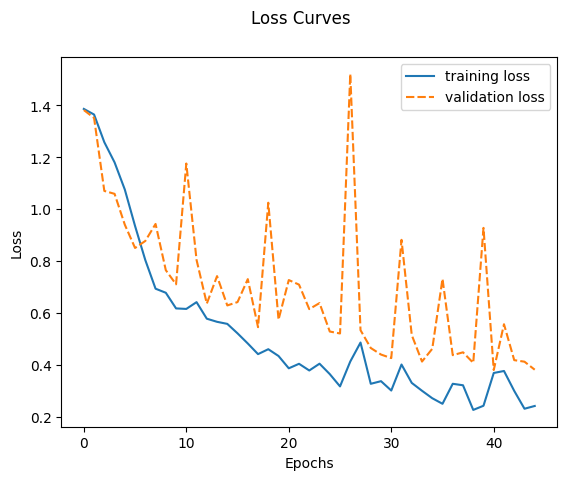

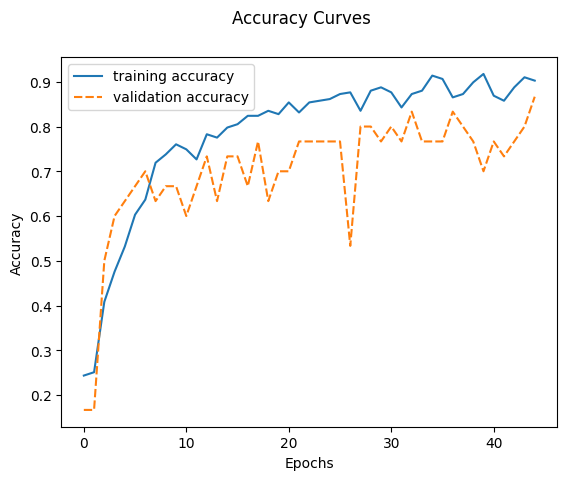

In [14]:
sns.lineplot(data= df_train_loss).set(xlabel="Epochs", ylabel="Loss")
plt.suptitle(t="Loss Curves")
plt.show()

sns.lineplot(data = df_train_acc).set(xlabel="Epochs", ylabel="Accuracy")
plt.suptitle(t="Accuracy Curves")
plt.show()

# Additional

Things to watch for in your graph:
- Training and validation accuracy SHOULD increase per epoch. 

- Very low Validation/Training curve comparative to the other curve: Data was not normalized

Overfitting

- Big/Growing gap between training and validation accuracy: Model is memorizing the training data instead of generalizing patterns.

- Validation accuracy reaches a peak then stays/declines (but training accuracy increases): Model is too complex/is fitting noise or irrelevant patterns from the training data.

- Sudden Drops in validation accuracy (but training accuracy increases): Model has started to learn specific patterns or outliers in the training data that do not generalize well.

- Erratic behavior, sharp spikes, sudden drops/increase in accuracy

Underfitting
- High training loss: Model struggles to capture the patterns and complexities of the training data/unable to fit the data well.

- High training accuracy, low validation accuracy: Model fails to generalize to unseen examples.

- Train and Validation curves converge slowly

- Loss curve may plateauing at a relatively high value without significant improvement: suggesting that the model is not learning the underlying patterns of the data.
Mean convergence epoch = somewhere between 27-44 (32)

- Large gap between training and validation loss

<h4>Edited Model and Augmented Dataset

- Balance out the number of samples in each class (Manually)
- Correct any mis-labelling in any of the 4 classes (Manually) 
    [banana_61, banana_35]
- Increased number of layers (high impact)
- (?) Automatically augment

In [15]:
# # Set Variables
# img_size = 224
# epochs = 64
# modeltype = '000'
# subfoldername='01EDIT'